<a href="https://colab.research.google.com/github/yyguo50170/dlg/blob/main/Deep_Leakage_from_Gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)

2.0.1+cu118 0.15.2+cu118


In [ ]:
dst = datasets.CIFAR100("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

def dlg_attack(gt_data,gt_onehot_label,net,original_dy_dx,epoch):
    # generate dummy data and label
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

    plt.imshow(tt(dummy_data[0].cpu()))
    plt.title("Dummy data")
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

    history = []
    for iters in range(10000):
        def closure():
            optimizer.zero_grad()

            pred = net(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()
            # grad_diff = grad_diff / grad_count * 1000
            grad_diff.backward()

            return grad_diff

        optimizer.step(closure)
        if iters % 10 == 0:
            current_loss = closure()
            print(iters, "%.4f" % current_loss.item())
        history.append(tt(dummy_data[0].cpu()))
        if current_loss.item() < 0.0001:
          print("global epoch:{}, converge dlg iters:{}".format(epoch,iters))
          break
    plt.figure()
    plt.imshow(history[-1])
    plt.title("Final dummy data")
    plt.show()

    #plt.figure(figsize=(12, 8))
    # for i in range(600):
    #   plt.subplot(3, 10, i + 1)
    #   plt.imshow(history[i * 10])
    #   plt.title("iter=%d" % (i * 10))
    #   plt.axis('off')
    # plt.savefig('/content/dlg_cifar100_epoch{}.png'.format(epoch))
    print("Final dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

Files already downloaded and verified
Running on cuda


In [ ]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

net = LeNet().to(device)

net.apply(weights_init)
criterion = cross_entropy_for_onehot

Files already downloaded and verified
GT label is 84. 
Onehot label is 84.
dlg epoch: 1
Dummy label is 64.
0 32.5726
10 0.5971
20 0.1446
30 0.0331
40 0.0062
50 0.0016
60 0.0005
70 0.0002
80 0.0001
global epoch:1, converge dlg iters:80


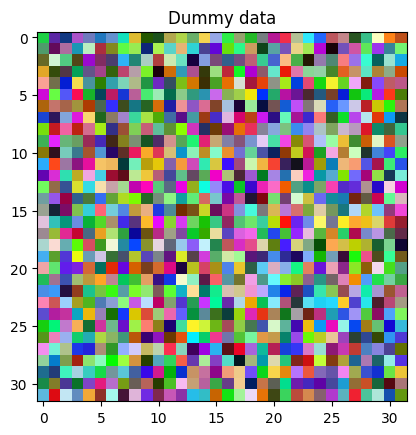

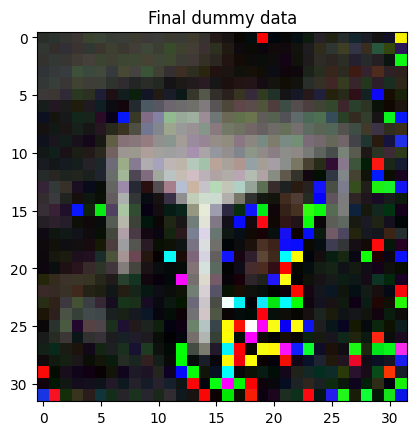

Final dummy label is 84.
epoch:2   Epoch [1/1], Step [700/782], Loss: 4.1868
epoch:3   Epoch [1/1], Step [700/782], Loss: 3.5779
epoch:4   Epoch [1/1], Step [700/782], Loss: 3.6643
epoch:5   Epoch [1/1], Step [700/782], Loss: 3.6119
epoch:6   Epoch [1/1], Step [700/782], Loss: 3.5576
epoch:7   Epoch [1/1], Step [700/782], Loss: 3.1159
epoch:8   Epoch [1/1], Step [700/782], Loss: 3.0193
epoch:9   Epoch [1/1], Step [700/782], Loss: 3.1194
epoch:10   Epoch [1/1], Step [700/782], Loss: 3.1223
epoch:11   Epoch [1/1], Step [700/782], Loss: 2.9867
epoch:12   Epoch [1/1], Step [700/782], Loss: 3.3351
epoch:13   Epoch [1/1], Step [700/782], Loss: 3.2510
epoch:14   Epoch [1/1], Step [700/782], Loss: 2.5711
epoch:15   Epoch [1/1], Step [700/782], Loss: 2.9192
epoch:16   Epoch [1/1], Step [700/782], Loss: 3.0049
epoch:17   Epoch [1/1], Step [700/782], Loss: 2.8406
epoch:18   Epoch [1/1], Step [700/782], Loss: 3.2599
epoch:19   Epoch [1/1], Step [700/782], Loss: 2.9682
epoch:20   Epoch [1/1], Step 

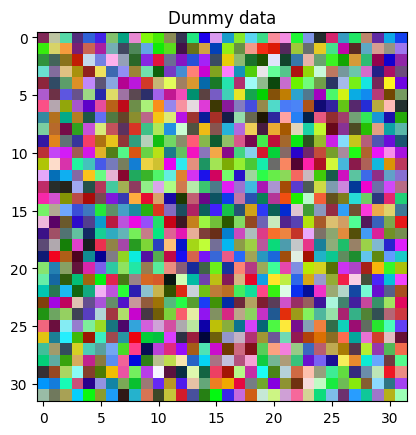

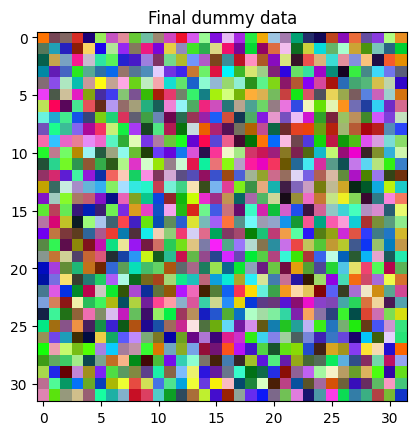

Final dummy label is 84.
epoch:52   Epoch [1/1], Step [700/782], Loss: 2.2362
epoch:53   Epoch [1/1], Step [700/782], Loss: 2.4654
epoch:54   Epoch [1/1], Step [700/782], Loss: 2.2039
epoch:55   Epoch [1/1], Step [700/782], Loss: 2.3312
epoch:56   Epoch [1/1], Step [700/782], Loss: 2.2934
epoch:57   Epoch [1/1], Step [700/782], Loss: 2.3260
epoch:58   Epoch [1/1], Step [700/782], Loss: 2.2659
epoch:59   Epoch [1/1], Step [700/782], Loss: 2.3456


KeyboardInterrupt: ignored

In [ ]:
######### honest partipant #########

# Hyper-parameters
epochs = 1000
local_eoochs = 1
batch_size = 64
learning_rate = 0.001

# CIFAR-100 dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

#train_dataset = datasets.CIFAR100(root='./torch', train=True, transform=transform, download=True)
train_dataset = datasets.CIFAR100(root='./torch', train=True, transform=tp, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

train_criterion = nn.CrossEntropyLoss()
train_optimizer = optim.Adam(net.parameters(), lr=learning_rate)



#攻击用数据
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())
for i in range(epochs):
  if i % 50 != 0:
    # Train the model
    total_step = len(train_loader)
    for local_epoch in range(local_eoochs):
      for j, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = net(images)
          loss = train_criterion(outputs, labels)

          # Backward and optimize
          train_optimizer.zero_grad()
          loss.backward()
          train_optimizer.step()

          if (j+1) % 700 == 0:
              print ('epoch:{}   Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(i+1,local_epoch+1, local_eoochs, j+1, total_step, loss.item()))

  else:

    # img_index = 25
    # gt_data = tp(dst[img_index][0]).to(device)
    # gt_data = gt_data.view(1, *gt_data.size())
    # gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
    # gt_label = gt_label.view(1, )
    # gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

    # plt.imshow(tt(gt_data[0].cpu()))
    # plt.title("Ground truth image")
    # print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

    # compute original gradient
    out = net(gt_data)
    y = criterion(out, gt_onehot_label)
    dy_dx = torch.autograd.grad(y, net.parameters())


    # share the gradients with other clients
    original_dy_dx = list((_.detach().clone() for _ in dy_dx))
    print('dlg epoch:',i+1)
    dlg_attack(gt_data,gt_onehot_label,net,original_dy_dx,i+1)
    for server_param, grad_param in zip(net.parameters(), dy_dx):
      server_param.data = server_param.data - learning_rate * grad_param.data.clone()


In [ ]:
# generate dummy data and label
# dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
# dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

# plt.imshow(tt(dummy_data[0].cpu()))
# plt.title("Dummy data")
# print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [ ]:
# optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

# history = []
# for iters in range(300):
#     def closure():
#         optimizer.zero_grad()

#         pred = net(dummy_data)
#         dummy_onehot_label = F.softmax(dummy_label, dim=-1)
#         dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
#         dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

#         grad_diff = 0
#         grad_count = 0
#         for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
#             grad_diff += ((gx - gy) ** 2).sum()
#             grad_count += gx.nelement()
#         # grad_diff = grad_diff / grad_count * 1000
#         grad_diff.backward()

#         return grad_diff

#     optimizer.step(closure)
#     if iters % 10 == 0:
#         current_loss = closure()
#         print(iters, "%.4f" % current_loss.item())
#     history.append(tt(dummy_data[0].cpu()))

In [ ]:
# plt.figure(figsize=(12, 8))
# for i in range(30):
#   plt.subplot(3, 10, i + 1)
#   plt.imshow(history[i * 10])
#   plt.title("iter=%d" % (i * 10))
#   plt.axis('off')
# print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())